In [1]:
import os, torch, joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model import *
from utils import *
from data_loader import *
from test_metrics import *
from preprocess.gaussianize import *
from scipy.stats import wasserstein_distance
from statsmodels.tsa.stattools import acf

path = '/workspace/QuantGAN_stock'
try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory {0} does not exist".format(path))
    
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)
sns.set(style="darkgrid")


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: /workspace/QuantGAN_stock


In [2]:
# Define the Configuration
full_name = 'num_G_5_400_64_lr_0.0005_skilled-gorge-239_clip_0.01'
dataset = "indices"
num_G = 5
seq_len = 127
batch_size = 100

In [3]:
# Load the Real Data for Transformer input
log_returns_preprocessed = joblib.load(f'./Dataset/log_returns_preprocessed.pkl')
data_loader = dataloader(log_returns_preprocessed, seq_len)    
train_loader = torch.utils.data.DataLoader(data_loader, batch_size, shuffle=True)

In [4]:
# Find the best epoch
asset_idx = 0
window = 100
min_emd = 0
best_epochs = 0

min_distance = float('inf')
noise = torch.randn(batch_size, 5, seq_len).to(device)

for epoch in range(0, 60, 2):
    generator_tmp = LSTMGenerator(latent_dim=5, ts_dim=5).to(device)
    generator_tmp.load_state_dict(torch.load(f'./Results/{full_name}/Generator_{epoch}.pt'))
    generator_tmp.eval()
     
    y = generator_tmp(noise).cpu().detach().squeeze()
    y, log_returns = inverse_process(y[:, asset_idx:asset_idx+1, :].squeeze(), asset_idx)
    if y.size == 0:            
        continue
        
    real_dist = rolling_window(log_returns, window).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, window).sum(axis=0).ravel()       
    
    emd = wasserstein_distance(real_dist, fake_dist)
    if emd < min_distance:
        min_distance = emd
        best_epochs = epoch
        min_emd = min_distance
        print(f"min_distance:{min_distance}, best_epochs:{epoch}")
        
print("best epochs:", best_epochs)

min_distance:0.1132321396548569, best_epochs:0
min_distance:0.07763895082158434, best_epochs:14
min_distance:0.07708136528813805, best_epochs:18
best epochs: 18


In [5]:
# generate the data based on best epoch
generator = LSTMGenerator(latent_dim=5, ts_dim=5).to(device)
generator.load_state_dict(torch.load(f'./Results/{full_name}/Generator_{best_epochs}.pt'))
generator.eval()

LSTMGenerator(
  (lstm): LSTM(5, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=5, bias=True)
)

In [6]:
fake_list = []
real_list = []
real = []
noise = torch.randn(5000, 5, 127).to(device)
fake = generator(noise).cpu().detach().squeeze()

for i in range(0, num_G):
        
    y_tmp, log_returns = inverse_process(fake[:, i:i+1, :].squeeze(), i)        
    
    y_tmp = y_tmp[(y_tmp.max(axis=1) <= 2.0 * log_returns.max()) & (y_tmp.min(axis=1) >= 2.0 * log_returns.min())]
    print(y_tmp.shape)
    
    fake_list.append(y_tmp)
    real.append(log_returns)

# 합성 데이터 저장
joblib.dump(fake_list, './fake_list.pkl')

for i in range(len(real)):        
    real_list.append(np.array(rolling_window_seqlen(real[i], 127)).squeeze())


(5000, 127)
(4994, 127)
(5000, 127)
(4996, 127)
(5000, 127)


In [7]:
print(type(real))
print(len(real), real[0].shape, '\n')

print(type(real_list))
print(len(real_list), real_list[0].shape, '\n')

print(type(fake_list))
print(len(fake_list), fake_list[0].shape)

<class 'list'>
5 (5031, 1) 

<class 'list'>
5 (4904, 127) 

<class 'list'>
5 (5000, 127)


Text(0, 0.5, 'log return path')

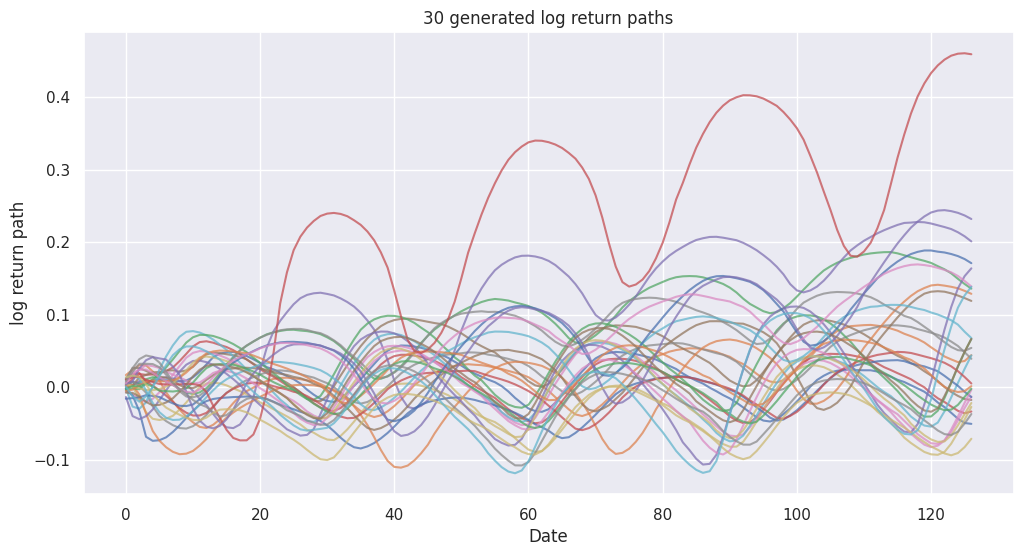

In [8]:
# # plot the 30 generated log return paths
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.cumsum(fake_list[0][0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths')
ax.set_xlabel('Date')
ax.set_ylabel('log return path')

In [9]:
windows = [1, 5, 20, 100]
for j in range(num_G):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(32, 6))  

    for i in range(len(windows)):
        col = i

        real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=0).ravel()
        
        # 두 데이터의 최소값과 최대값을 계산
        min_val = min(real_dist.min(), fake_dist.min())
        max_val = max(real_dist.max(), fake_dist.max())

        # 동일한 bin 경계 계산 (간격 동일하게)
        bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
        sns.histplot(real_dist, bins=bins, kde=True, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=True, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

        axs[col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
        
        axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
        axs[col].yaxis.grid(True, alpha=0.5)
        axs[col].set_xlabel('Cumulative log return', fontsize=12)
        axs[col].set_ylabel('Frequency', fontsize=12)

    axs[0].legend(['Historical returns', 'Synthetic returns'])

plt.show()

In [ ]:
# Correlation Analysis of synthetic data
df_fake = []        
for i in range(num_G):
    
    y_tmp, log_returns = inverse_process(fake[:, i:i+1, :].squeeze(), i)        
    df_tmp = pd.DataFrame(y_tmp)
    df_fake.append(df_tmp)
    
df_fake_merge = pd.concat(df_fake, axis=1)

corr_fake, _, _ = calculate_correlation(df_fake_merge, seq_len)

### Correlation Analysis - real data
real_merge = np.transpose(np.stack(real_list), axes=(1, 0, 2))
real_merge = real_merge.reshape(real_merge.shape[0], -1)
df_real_merge = pd.DataFrame(real_merge)
_, avg_real, _ = calculate_correlation(df_real_merge, seq_len)

In [ ]:
mae_mean, mae_std = calculate_mae(avg_real, corr_fake)
frobenius_mean, frobenius_std = calculate_frobenius(avg_real, corr_fake)
spearman_mean, spearman_std = calculate_spearman(avg_real, corr_fake)
kendall_mean, kendall_std = calculate_kendall(avg_real, corr_fake)

print("MAE mean:", mae_mean, "MAE std:", mae_std)
print("Frobenius mean:", frobenius_mean, "Frobenius std:", frobenius_std)
print("Spearman mean:", spearman_mean, "Spearman std:", spearman_std)
print("Kendall mean:", kendall_mean, "Kendall std:", kendall_std)

In [ ]:
# ACF 비교 플롯
plot_acf_comparison(real_list, fake_list, num_G, lags=30)

In [ ]:
acf_score = calculate_acf_score(real_list, fake_list)

# Display the scores for each group
for group, scores in acf_score.items():
    print(f"{group}:")
    for title, score in scores.items():
        print(f"  {title}: {score}")
